# Tutorial: Overfitting/Underfitting and Bias/Variance

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2F03_tutorial_overfitting_underfitting_bias_variance.ipynb)

Tutorial to the class [Overfitting/Underfitting and Bias/Variance](03_overfitting_underfitting_bias_variance.ipynb) based on the same case study as in [Tutorial: Supervised Learning Problem and Least Squares](02_tutorial_supervised_learning_problem_ols.ipynb).

<div class="alert alert-block alert-info">
    <b>Tutorial Objectives</b>
    
- Evaluate model performance by estimating the Expected Prediction Errors (EPE) using test data
- Same as above but with cross-validation
- Compute and plot learning curves
- Improve the models by modifying the input features
</div>

## Getting ready

Let us follow the same procedure as in [Tutorial: Supervised Learning Problem and Least Squares](02_tutorial_supervised_learning_problem_ols.ipynb) to import the required modules and read the data.

In [1]:
# Path manipulation module
from pathlib import Path
# Numerical analysis module
import numpy as np
# Formatted numerical analysis module
import pandas as pd
# Plot module
import matplotlib.pyplot as plt
# Default colors
RC_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Set data directory
data_dir = Path('data')

# Set keyword arguments for pd.read_csv
kwargs_read_csv = dict()

# Set first and last years
FIRST_YEAR = 2014
LAST_YEAR = 2019

# Define temperature filepath
temp_filename = 'surface_temperature_merra2_{}-{}.csv'.format(
    FIRST_YEAR, LAST_YEAR)
temp_filepath = Path(data_dir, temp_filename)

# Define electricity demand filepath
dem_filename = 'reseaux_energies_demand_demand.csv'
dem_filepath = Path(data_dir, dem_filename)

# Read hourly temperature and demand data averaged over each region
df_temp_hourly = pd.read_csv(temp_filepath, index_col=0, parse_dates=True, header=0)
df_dem_hourly = pd.read_csv(dem_filepath, index_col=0, header=0, parse_dates=True)

# Get daily-mean temperature and daily demand
df_temp = df_temp_hourly.resample('D').mean()
df_dem = df_dem_hourly.resample('D').sum()

# Select Île-de-France region
region_name = 'Île-de-France'
df_temp_idf = df_temp[region_name]
df_dem_idf = df_dem[region_name]

## Estimating the prediction error using a test set

> ***Question***
> - Estimate the prediction error (prediction $R^2$) from 1 year of test data for Île-de-France using the other years to train an OLS.
> - How does it compare to the train error estimated from the train data?
> - Is the prediction $R^2$ an estimate of the expected prediction error or of the prediction error conditioned on some train dataset?
> - Do you expect overfitting to have occurred?

Estimated coefficients:
intercept	5.24e+05
slope		-1.18e+04

Train R2:	0.76
Test R2:	0.73


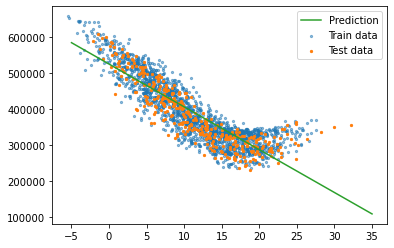

In [36]:
# Import
from sklearn import linear_model

# Prepare input and output for fit
X = df_temp_idf.values[:, None]
y = df_dem_idf.values

# Number of test days
n_test = 365

# Select test set from last year
X_test = X[-n_test:]
y_test = y[-n_test:]


# Select train set from previous years
X_train = X[:-n_test]
y_train = y[:-n_test]

# Fit model on train data
reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(X_train, y_train)
print('Estimated coefficients:')
print('intercept\t{:.2e}'.format(reg.intercept_))
print('slope\t\t{:.2e}'.format(reg.coef_[0]))

# Get train score
r2_train = reg.score(X_train, y_train)
print('\nTrain R2:\t{:.2f}'.format(r2_train))

# Get test score
r2_test = reg.score(X_test, y_test)
print('Test R2:\t{:.2f}'.format(r2_test))

plt.scatter(X_train[:, 0], y_train, s=5, alpha=0.5, label='Train data')
plt.scatter(X_test[:, 0], y_test, s=5, alpha=1, label='Test data')
x = np.linspace(-5., 35., 100)
y_pred = reg.predict(x[:, None])
plt.plot(x, y_pred, color=RC_COLORS[2], label='Prediction')
plt.legend()

Answer:

> ***Question***
> - How does the prediction error change if it is computed based on the last 3 months of the year instead?
> - Give at least 2 reasons to explain these changes.

Estimated coefficients:
intercept	5.22e+05
slope		-1.17e+04

Train R2:	0.75
Test R2:	0.54


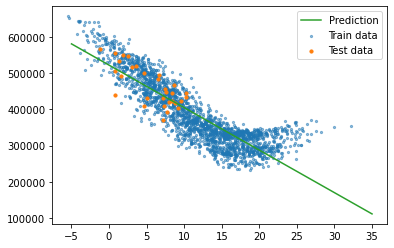

In [37]:
# Number of test days
n_test = 30

# Select test set from last year
X_test = X[-n_test:]
y_test = y[-n_test:]


# Select train set from previous years
X_train = X[:-n_test]
y_train = y[:-n_test]

# Fit model on train data
reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(X_train, y_train)
print('Estimated coefficients:')
print('intercept\t{:.2e}'.format(reg.intercept_))
print('slope\t\t{:.2e}'.format(reg.coef_[0]))

# Get train score
r2_train = reg.score(X_train, y_train)
print('\nTrain R2:\t{:.2f}'.format(r2_train))

# Get test score
r2_test = reg.score(X_test, y_test)
print('Test R2:\t{:.2f}'.format(r2_test))

plt.scatter(X_train[:, 0], y_train, s=5, alpha=0.5, label='Train data')
plt.scatter(X_test[:, 0], y_test, s=10, alpha=1, label='Test data')
x = np.linspace(-5., 35., 100)
y_pred = reg.predict(x[:, None])
plt.plot(x, y_pred, color=RC_COLORS[2], label='Prediction')
plt.legend()

Answer:

### Learning curve

> ***Question***
> - Compute and plot a learning curve. To do so:
>   - Set 1 year of data aside to compute the test error always on the same period
>   - Define a list of train period of increasing lengths
>   - Loop over these train periods to iteratively:
>     - Select data for this train period
>     - Train the model
>     - Compute the train error from the train data for the train period
>     - Compute the test error from the test data for the test period
>     - Save both errors
>   - Plot both errors curves
> - Interpret the results.

In [38]:
# Define function to get learning curve for a given number of test days
def get_learning_curve(X, y, n_test, fit_intercept=True):
    X_test = X[-n_test:]
    y_test = y[-n_test:]

    # Select train set from previous years
    X_train = X[:-n_test]
    y_train = y[:-n_test]

    # Define the number of days by which to increase the train periods
    step = 30
    n_days = np.arange(step, X_train.shape[0], step)

    # Define arrays in which to save the errors
    r2_trains = np.empty(n_days.shape)
    r2_tests = np.empty(n_days.shape)

    # Loop over train periods stopping before overlapping test period
    for idx, nd in enumerate(n_days):
        # Select for the number of days
        X_train_nd = X_train[:nd]
        y_train_nd = y_train[:nd]

        # Fit
        reg = linear_model.LinearRegression(fit_intercept=fit_intercept)
        reg.fit(X_train_nd, y_train_nd)

        # Get the train score
        r2_train = reg.score(X_train_nd, y_train_nd)

        # Get the test score
        r2_test = reg.score(X_test, y_test)

        r2_trains[idx] = r2_train
        r2_tests[idx] = r2_test
        
    # Print final R2
    print('Final train R2: \t{:.2f}'.format(r2_trains[-1]))
    print('Final test R2: \t\t{:.2f}'.format(r2_tests[-1]))


    # Plot the learning curves
    plt.figure()
    plt.plot(n_days, r2_trains, label='Train R2')
    plt.plot(n_days, r2_tests, label='Test R2')
    plt.ylim(0., 1.)
    plt.legend()

Final train R2: 	0.76
Final test R2: 		0.73


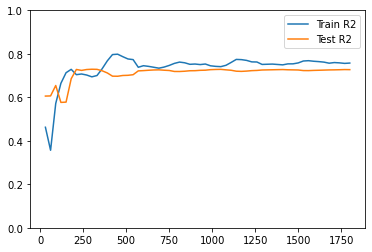

In [39]:
# Select test set from last year
N_TEST = 365

# Prepare input and output for fit
X = df_temp_idf.values[:, None]
y = df_dem_idf.values


get_learning_curve(X, y, N_TEST)

Answer: 

> ***Question***
> - Same question as above but for 2 years of test data.
> - Compare the results using 1 year and 2 years of test data.

Final train R2: 	0.75
Final test R2: 		0.76


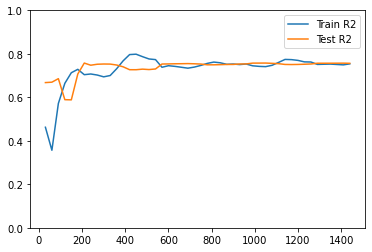

In [40]:
N_TEST = 365 * 2
get_learning_curve(X, y, N_TEST)

Answer: 

## Estimating the expected prediction error with cross-validation

> ***Question***
> - Perform a $k$-fold cross-validation of your own by repeating the above estimation of the test error on all years. To do so:
>   - Use the `split` method of a `sklearn.model_selection.KFold` object initialized with the `n_splits` option to get a sequence train and test indices over which to loop.
>   - For each pair of train and test indices:
>     - Select the train and test data from the input and output data;
>     - Fit the model using the train data;
>     - Use the fitted model to predict the target from the test inputs;
>     - Estimate the $R^2$ from the test output.
>   - Average the $R^2$ estimates.

In [44]:
# Import
from sklearn.model_selection import KFold

# Number of splits
N_SPLITS = len(df_temp) // 365

# Define k-fold iterator
kf = KFold(n_splits=N_SPLITS)

# Loop over the train and test indices
r2_test_arr = np.empty((N_SPLITS,))
for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Select the train and test inputs
    X_train, X_test = X[train_index], X[test_index]

    # Select the train and test targets
    y_train, y_test = y[train_index], y[test_index]

    # Fit the OLS model using the train data
    reg = linear_model.LinearRegression(fit_intercept=True)
    reg.fit(X_train, y_train)

    # Predict the test target
    y_pred = reg.predict(X_test)

    # Compute test R2
    r2_test_arr[i] = reg.score(X_test, y_test)

# Average R2 and print
r2_test_mean = np.mean(r2_test_arr)
print('List of R2:')
for i, r2_test in enumerate(r2_test_arr):
    print('\tFold {:d}: {:.2f}'.format(i, r2_test))
print('Average test R2: {:.2f}'.format(r2_test_mean))

List of R2:
	Fold 0: 0.74
	Fold 1: 0.73
	Fold 2: 0.78
	Fold 3: 0.76
	Fold 4: 0.78
	Fold 5: 0.73
Average test R2: 0.75


> ***Question***
> - Verify your results using the `cross_val_score` function of `sklearn.model_selection` with the appropriate value for the `cv` option.
> - How does the $R^2$ estimate from the cross-validation compare to your estimation above?

In [45]:
# Import scikit-learn cross-validation function
from sklearn.model_selection import cross_val_score

r2_test_arr = cross_val_score(reg, X, y, cv=N_SPLITS)
r2_test_mean = np.mean(r2_test_arr)
print('List of R2:')
for i, r2_test in enumerate(r2_test_arr):
    print('\tFold {:d}: {:.2f}'.format(i, r2_test))
print('Average test R2: {:.2f}'.format(r2_test_mean))

List of R2:
	Fold 0: 0.74
	Fold 1: 0.73
	Fold 2: 0.78
	Fold 3: 0.76
	Fold 4: 0.78
	Fold 5: 0.73
Average test R2: 0.75


Answer: 

## Improving the linear model by adding features

We know from consumer behavior and heating technologies that individual heating tends to increase linearly from no heating below some heating temperature $T_H \approx 15$°C.

This "heating" function is coded below and returned as a dictionnary.

In [46]:
# Heating-temperature threshold
TEMP_HEAT = 15.

# Define function returning a dictionary from variable name
# to variable train data with base and heating variables
def get_heat(x):
    return {
        'heat': (TEMP_HEAT - x) * (x < TEMP_HEAT).astype(float)
    }

> ***Question***
> - Fit the heating model and plot its predictions.
> - Compute the train and test learning curves for this model.
> - Compare the results to the one-dimensional model and explain.

Final train R2: 	0.84
Final test R2: 		0.86


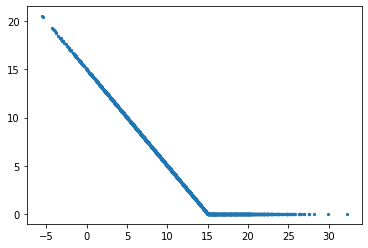

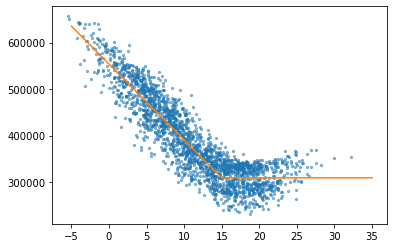

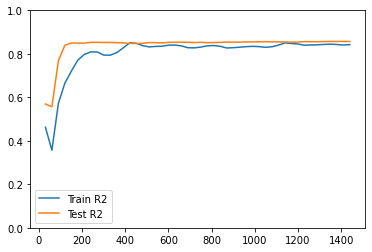

In [47]:
# Define function to fit and plot piecewise linear regression
def fit_piecewise_linear(get_variables, x_train, y_train, x_test):
    # Get variables to train
    variables_train = get_variables(x_train)
    
    # Create input matrix with a column for each variable
    X_train = np.empty((len(x_train), len(variables_train)))
    
    # Loop over train variables pairs
    plt.figure()
    for i, (variable_name, variable_data) in enumerate(
        variables_train.items()):
        # Add variable data to input matrix
        X_train[:, i] = variable_data
        
        # Plot variable
        plt.scatter(x_train, variable_data, label=variable_name, s=5)
     
    # Fit OLS
    reg = linear_model.LinearRegression(fit_intercept=True)
    reg.fit(X_train, y_train)
    
    # Get variables to test
    variables_test = get_variables(x_test)
    
    # Create input matrix with a column for each variable
    X_test = np.empty((len(x_test), len(variables_test)))
    
    # Loop over train variables pair
    for i, (variable_name, variable_data) in enumerate(
        variables_test.items()):
        # Add variable data to input matrix
        X_test[:, i] = variable_data
        
    # Get prediction from test input
    y_pred = reg.predict(X_test)

    # Plot prediction over train data
    plt.figure()
    plt.scatter(x_train, y_train, s=5, alpha=0.5)
    plt.plot(x_test, y_pred, color=RC_COLORS[1])
    
    # Get learning curve without fitting intercept
    N_TEST = 365 * 2
    get_learning_curve(X_train, y_train, N_TEST)
    
# Prepare input and target to train
x_train = df_temp_idf.values
y_train = df_dem_idf.values

# Define input test data
x_test = np.linspace(-5., 35., 100)

fit_piecewise_linear(get_heat, x_train, y_train, x_test)

Answer:

In southern regions where climates are relatively warm, air conditioning may be used when daily-mean temperatures increase above about 20°C.
As a result, regional electricity demand increases somewhat linearly above this threshold.

This "cooling" function is coded below and returned as a dictionnary together with the "heating" function defined above.

In [48]:
#Cooling-temperature threshold
TEMP_COOL = 20.

# Define function returning a dictionary from variable name
# to variable train data with base, heating and cooling variables
def get_heat_cool(x):
    return {
        'heat': (TEMP_HEAT - x) * (x < TEMP_HEAT).astype(float),
        'cool': (x - TEMP_COOL) * (x > TEMP_COOL).astype(float)
    }

> ***Question***
> - Apply and validate the heating and cooling model to the `"Provence-Alpes-Côte d'Azur"` region.
> - Compare the skills of the linear model, the heating model and the heating and cooling model.


Linear model:
Final train R2: 	0.55
Final test R2: 		0.53

Heating model:
Final train R2: 	0.76
Final test R2: 		0.77

Heating and cooling model:
Final train R2: 	0.79
Final test R2: 		0.82


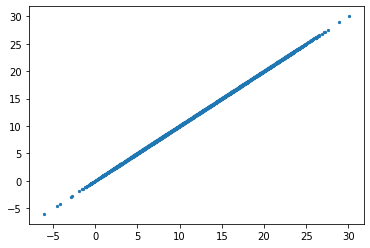

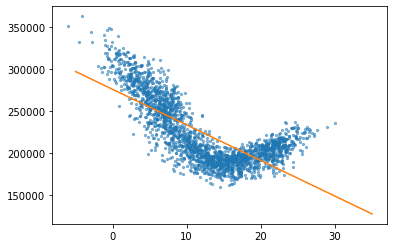

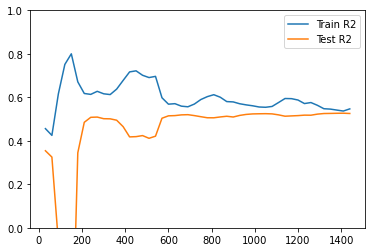

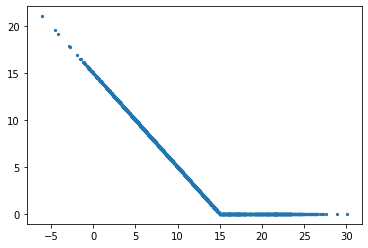

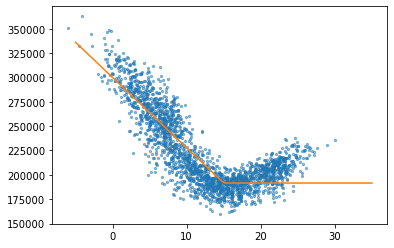

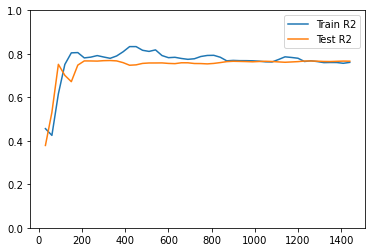

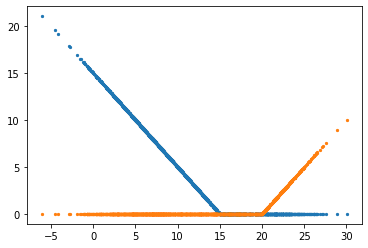

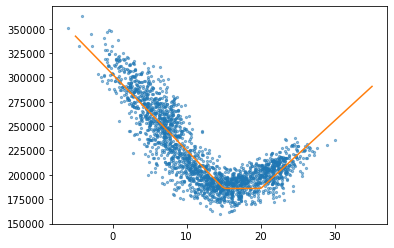

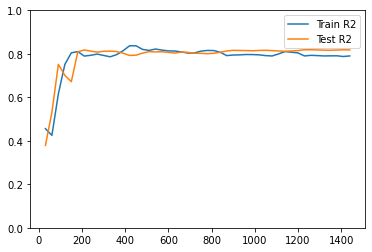

In [49]:
# Select data for given region
region_name = "Provence-Alpes-Côte d'Azur"
df_temp_reg = df_temp[region_name]
df_dem_reg = df_dem[region_name]

# Prepare input and target to train
x_train = df_temp_reg.values
y_train = df_dem_reg.values

print('\nLinear model:')
fit_piecewise_linear(lambda x: {'slope': x}, x_train, y_train, x_test)

print('\nHeating model:')
fit_piecewise_linear(get_heat, x_train, y_train, x_test)

print('\nHeating and cooling model:')
fit_piecewise_linear(get_heat_cool, x_train, y_train, x_test)

Answer: 

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>